In [1]:
# %reset
# %load_ext autoreload
# %autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from info.utils.pdf_computer import pdfComputer
from info.models.logistic_network import Logistic
from info.utils.causal_network import search_mpid_condition, causal_network
from info.utils.others import reorganize_data, normalize
from info.core.info import info
from info.core.info_network import info_network

%matplotlib inline

In [3]:
# The number of bins in each dimension
n1, n2, n3 = 10, 25, 30

# Settings for plot
# plt.rcParams["figure.figsize"] = (5,4)
# plt.rcParams["axes.titlesize"] = 18
# plt.rcParams["axes.labelsize"] = 18
# plt.rcParams["xtick.labelsize"] = 18
# plt.rcParams["ytick.labelsize"] = 18

# Generate the variable values
lag  = 1
e    = 1.
ez   = .2
# n    = 2
# adjM = np.array([[0, 0], [1, 0]])
# lagM = np.array([[0, 0], [lag, 0]])
n    = 3
adjM = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
lagM = np.array([[0, lag, lag], [lag, 0, lag], [lag, lag, 0]])

# Parameters for simulation
approach='kde_cuda'
nstep = 3000
noiseType = 'additive'
noiseDist = 'uniform'
noiseOn   = [1, 1, 1]
noisePara = [1, 0, 1]

# Define the corresponding causalDict
causalDict = {0: [(1,-1), (2,-1)],
              1: [(0,-1), (2,-1)],
              2: [(0,-1), (1,-1)]}
taumax=5
sidepath=False
verbosity=1

# Generate the outputs
logistic = Logistic(n, adjM, lagM, e, ez, noiseType=noiseType, 
                    noiseDist=noiseDist, noisePara=noisePara)
results = logistic.simulate(nstep)
# d1, d2, d3 = results[0,:], results[1,:], results[2,:]

# Normalize the data
data = normalize(results.T)

# Initialize the networks
network1 = info_network(data, causalDict, 
                        pdfest=approach, kernel='gaussian', nx=n1, taumax=taumax)
# network2 = info_network(data, causalDict, 
#                         pdfest=approach, kernel='epanechnikov', nx=n1, taumax=taumax)

In [4]:
# 2D -- unconditioned
# Define the source and the target
sind, tind = 0, 1
testinfo11set = network1.compute_2n_infotrans_set(sind, tind, conditioned=False, 
                                                  taumax=taumax, normalized=True)
# testinfo12set = network2.compute_2n_infotrans_set(sind, tind, conditioned=False, 
#                                                   taumax=taumax, normalized=True)

In [5]:
# 2D -- conditioned
# Define the two sources and the target
# source, target = (0, -3), (1, 0)

# testinfo2 = network1.compute_2n_infotrans(source, target, conditioned=True, normalized=True)
# testinfo2.allInfo
# network1.network.check_links(source, target)
# network1.network.search_mit_condition(source, target)

# Define the source and the target
sind, tind = 0, 1
testinfo21set = network1.compute_2n_infotrans_set(sind, tind, conditioned=True, 
                                                  taumax=taumax, normalized=True, verbosity=1)
# testinfo22set = network2.compute_2n_infotrans_set(sind, tind, conditioned=True, 
#                                                   taumax=taumax, normalized=True, verbosity=1)

directed
The link type between (0, -1) and (1, 0) is directed
The number of conditions from (0, -1) to (1, 0) is 3, including:
[(2, -2), (2, -1), (1, -2)]
causalpath
The link type between (0, -2) and (1, 0) is causalpath
The number of conditions from (0, -2) to (1, 0) is 4, including:
[(2, -3), (1, -3), (0, -1), (1, -2)]
causalpath
The link type between (0, -3) and (1, 0) is causalpath
The number of conditions from (0, -3) to (1, 0) is 5, including:
[(0, -2), (1, -3), (2, -3), (1, -4), (2, -4)]
causalpath
The link type between (0, -4) and (1, 0) is causalpath
The number of conditions from (0, -4) to (1, 0) is 5, including:
[(1, -5), (0, -3), (1, -4), (2, -4), (2, -5)]
causalpath
The link type between (0, -5) and (1, 0) is causalpath
The number of conditions from (0, -5) to (1, 0) is 5, including:
[(1, -5), (2, -5), (1, -6), (0, -4), (2, -6)]
directed
The link type between (0, -1) and (1, 0) is directed
The number of conditions from (0, -1) to (1, 0) is 3, including:
[(2, -2), (2, -1), 

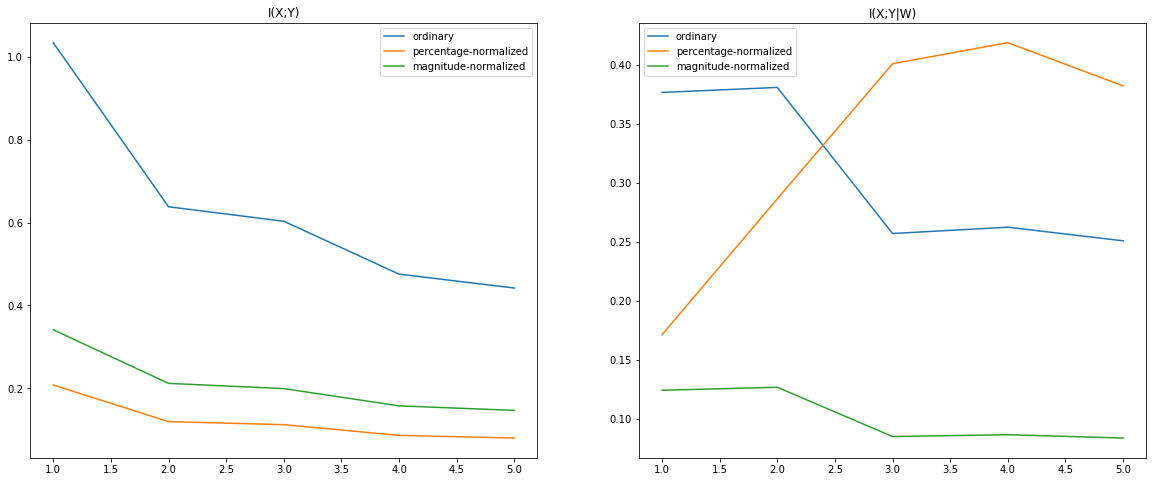

In [6]:
lags = range(1, taumax+1)
test1o = [testinfo.allInfo.loc['I(X;Y)', 'ordinary'] for testinfo in testinfo11set]
test1p = [testinfo.allInfo.loc['I(X;Y)', 'norm_p'] for testinfo in testinfo11set]
test1m = [testinfo.allInfo.loc['I(X;Y)', 'norm_m'] for testinfo in testinfo11set]
test2o = [testinfo.allInfo.loc['I(X;Y|W)', 'ordinary'] for testinfo in testinfo21set]
test2p = [testinfo.allInfo.loc['I(X;Y|W)', 'norm_p'] for testinfo in testinfo21set]
test2m = [testinfo.allInfo.loc['I(X;Y|W)', 'norm_m'] for testinfo in testinfo21set]

fig, axes = plt.subplots(1,2,figsize=(20,8))
axes[0].plot(lags, test1o, label='ordinary')
axes[0].plot(lags, test1p, label='percentage-normalized')
axes[0].plot(lags, test1m, label='magnitude-normalized')
axes[0].legend()
axes[0].set_title('I(X;Y)')

axes[1].plot(lags, test2o, label='ordinary')
axes[1].plot(lags, test2p, label='percentage-normalized')
axes[1].plot(lags, test2m, label='magnitude-normalized')
axes[1].legend()
axes[1].set_title('I(X;Y|W)')

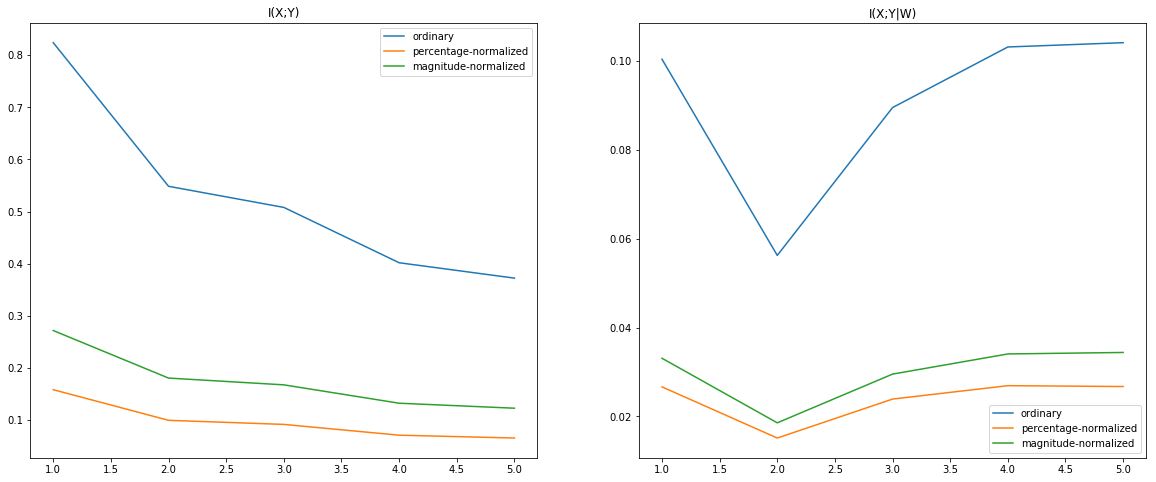

In [7]:
# lags = range(1, taumax+1)
# test1o = [testinfo.allInfo.loc['I(X;Y)', 'ordinary'] for testinfo in testinfo12set]
# test1p = [testinfo.allInfo.loc['I(X;Y)', 'norm_p'] for testinfo in testinfo12set]
# test1m = [testinfo.allInfo.loc['I(X;Y)', 'norm_m'] for testinfo in testinfo12set]
# test2o = [testinfo.allInfo.loc['I(X;Y|W)', 'ordinary'] for testinfo in testinfo22set]
# test2p = [testinfo.allInfo.loc['I(X;Y|W)', 'norm_p'] for testinfo in testinfo22set]
# test2m = [testinfo.allInfo.loc['I(X;Y|W)', 'norm_m'] for testinfo in testinfo22set]

# fig, axes = plt.subplots(1,2,figsize=(20,8))
# axes[0].plot(lags, test1o, label='ordinary')
# axes[0].plot(lags, test1p, label='percentage-normalized')
# axes[0].plot(lags, test1m, label='magnitude-normalized')
# axes[0].legend()
# axes[0].set_title('I(X;Y)')

# axes[1].plot(lags, test2o, label='ordinary')
# axes[1].plot(lags, test2p, label='percentage-normalized')
# axes[1].plot(lags, test2m, label='magnitude-normalized')
# axes[1].legend()
# axes[1].set_title('I(X;Y|W)')

In [12]:
# 3D -- unconditioned
# # Define the two sources and the target
# source1, source2 = (0, -1), (1, -1)
# target = (2, 0)

# testinfo3 = network1.compute_3n_infotrans(source1, source2, target, conditioned=False, normalized=True)

# Define the source and the target
s1ind, s2ind, tind = 0, 1, 2
testinfo3set = network1.compute_3n_infotrans_set(s1ind, s2ind, tind, conditioned=False, 
                                                 taumax=5, normalized=True)

In [13]:
# 3D -- conditioned
# # Define the two sources and the target
# source1, source2 = (0, -1), (1, -1)
# target = (2, 0)

# testinfo4 = network1.compute_3n_infotrans(source1, source2, target, conditioned=True, normalized=True)

# Define the source and the target
s1ind, s2ind, tind = 0, 1, 2
testinfo4set = network1.compute_3n_infotrans_set(s1ind, s2ind, tind, conditioned=True, 
                                                 taumax=5, normalized=True)

The number of conditions from (0, -1) and (1, -1) to (2, 0) is 3, including:
[(2, -2), (0, -2), (1, -2)]
The number of conditions from (0, -1) and (1, -2) to (2, 0) is 4, including:
[(2, -2), (0, -3), (2, -3), (1, -1)]
The number of conditions from (0, -1) and (1, -3) to (2, 0) is 5, including:
[(0, -3), (2, -3), (0, -4), (2, -4), (1, -2)]
The number of conditions from (0, -1) and (1, -4) to (2, 0) is 5, including:
[(2, -5), (1, -3), (0, -4), (2, -4), (0, -5)]
The number of conditions from (0, -1) and (1, -5) to (2, 0) is 5, including:
[(2, -5), (0, -6), (2, -6), (1, -4), (0, -5)]
The number of conditions from (0, -2) and (1, -1) to (2, 0) is 4, including:
[(2, -2), (2, -3), (1, -3), (0, -1)]
The number of conditions from (0, -2) and (1, -2) to (2, 0) is 4, including:
[(2, -2), (0, -3), (1, -3), (2, -3)]
The number of conditions from (0, -2) and (1, -3) to (2, 0) is 5, including:
[(0, -3), (2, -3), (0, -4), (2, -4), (1, -2)]
The number of conditions from (0, -2) and (1, -4) to (2, 0) i

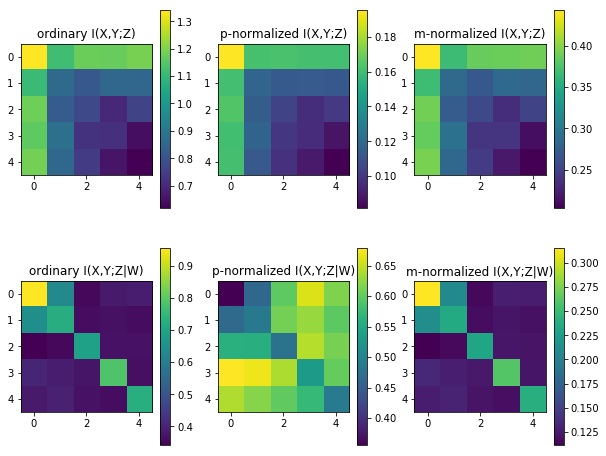

In [14]:
vectorize = np.vectorize(lambda info, metric, normtype: info.allInfo.loc[metric, normtype])
# testinfo4set= testinfo1set
# testinfo4set[0,0].allInfo
# vectorize(testinfo4set, 'I(X,Y;Z|W)', 'norm_p')

lags = range(1, taumax+1)
test1o = vectorize(testinfo3set, 'I(X,Y;Z)', 'ordinary')
test1p = vectorize(testinfo3set, 'I(X,Y;Z)', 'norm_p')
test1m = vectorize(testinfo3set, 'I(X,Y;Z)', 'norm_m')
test2o = vectorize(testinfo4set, 'I(X,Y;Z|W)', 'ordinary')
test2p = vectorize(testinfo4set, 'I(X,Y;Z|W)', 'norm_p')
test2m = vectorize(testinfo4set, 'I(X,Y;Z|W)', 'norm_m')

fig, axes = plt.subplots(2,3,figsize=(10,8))
cax = axes[0, 0].imshow(test1p, label='percentage')

ax = axes[0, 0]
cax = ax.imshow(test1o, label='magnitude')
ax.set_title('ordinary I(X,Y;Z)')
fig.colorbar(cax, ax = ax)

ax = axes[0, 1]
cax = ax.imshow(test1p, label='percentage')
ax.set_title('p-normalized I(X,Y;Z)')
fig.colorbar(cax, ax = ax)

ax = axes[0, 2]
cax = ax.imshow(test1m, label='magnitude')
ax.set_title('m-normalized I(X,Y;Z)')
fig.colorbar(cax, ax = ax)

ax = axes[1, 0]
cax = ax.imshow(test2o, label='magnitude')
ax.set_title('ordinary I(X,Y;Z|W)')
fig.colorbar(cax, ax = ax)

ax = axes[1, 1]
cax = ax.imshow(test2p, label='percentage')
ax.set_title('p-normalized I(X,Y;Z|W)')
fig.colorbar(cax, ax = ax)

ax = axes[1, 2]
cax = ax.imshow(test2m, label='magnitude')
ax.set_title('m-normalized I(X,Y;Z|W)')
fig.colorbar(cax, ax = ax)

In [11]:

# # Reorganize the data
# results1 = reorganize_data(results.T, [source, target])

# # Calculate the PDF
# pdfsolver1 = pdfComputer(ndim=2, approach='kde_c', 
#                          bandwidth='silverman', kernel='epanechnikov', base=2)
# _, pdf1, cd = pdfsolver1.computePDF(results1, nbins=[n1] * 2)

# # Plot
# xv, yv = np.meshgrid(cd[0], cd[1], indexing='ij')
# plt.contourf(xv, yv, pdf1)
# plt.title('PDF plot')
# plt.xlabel('x1(t-1)')
# plt.ylabel('x2(t)')
# plt.show()

# # Calculate the INFO
# test1_info = info(ndim=2, pdfs=pdf1)
# test1_info.normalizeinfo()
# test1_info.allInfo


# # Rearrange the results with the lag
# X, Y, Z = d1[:-lag]*.5, d2[:-lag], d3[lag:]
# results2 = np.array([X, Y, Z]).T

# # Generate the conditions for MPID
# w = network.search_mpid_condition(source1, source2, target, sidepath=sidepath, verbosity=verbosity)
# print w

# # Reorganize the data
# results22 = reorganize_data(results.T, [source1, source2, target] + w)
# # results22 = reorganize_data(results.T, [source1, source2, target])    
# print results22.shape

# # Calculate the PDF
# pdfsolver22 = pdfComputer(ndim='m', approach='kde_c', bandwidth='silverman', kernel='epanechnikov')
# _, pdf22, cd = pdfsolver22.computePDF(results22, nbins=[n1]*(3+len(w)))
# # xv, yv = np.meshgrid(cd[0], cd[2], indexing='ij')
# # plt.contourf(xv, yv, np.sum(pdf2,axis=(1)))

# # Calculate the INFO
# test22_info = info(ndim=3, pdfs=pdf22, conditioned=True)
# test22_info.normalizeinfo()
# test22_info.allInfo